## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython import display
import time
from tqdm import trange
from tqdm.notebook import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

In [3]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [4]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [42]:
y_train_ohe = pd.get_dummies(y_train, dtype=float).values
y_val_ohe = pd.get_dummies(y_val, dtype=float).values
y_test_ohe = pd.get_dummies(y_test, dtype=float).values

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [78]:
def get_activation_layer(func_name):
    if func_name == 'ReLU':
        return ReLU()
    elif func_name == 'ELU':
        return ELU()
    elif func_name == 'LeakyReLU':
        return LeakyReLU()
    elif func_name == 'SoftPlus':
        return SoftPlus()
    
    assert False, "The function name is not in {'ReLU', 'ELU', 'LeakyReLU', 'SoftPlus'}"
    
    
def add_layer_block(model, n_in, n_out, norm, activation_layer):
    model.add(Linear(n_in, n_out))
    
    if norm:
        model.add(BatchNormalization(alpha=0.9))
        model.add(ChannelwiseScaling(n_out))
        
    model.add(activation_layer)


def build_model(activation_func='ReLU', norm=True, dropout=False):
    model = Sequential()
    model.add(Flatten())
    add_layer_block(model, 784, 500, norm, get_activation_layer(activation_func))
    add_layer_block(model, 500, 225, norm, get_activation_layer(activation_func))
    if dropout:
        model.add(Dropout(p=0.3))
    model.add(Linear(225, 10))
        
    model.add(LogSoftMax())
    return model

In [66]:
def train_model(model, data, labels, batch_size, optim, criterion, n_epoch, 
                lr_scheduler_step_size = 1, lr_scheduler_coef = 1):
    losses = {'train': [], "val": []}
    accuracy = {'train': [], "val": []}
    since = time.time()

    for i in trange(n_epoch):
        ep_losses = {'train': [], "val": []}
        ep_acc = {'train': [], "val": []}
        
        if (i + 1) % lr_scheduler_step_size == 0:
            optimizer_config['learning_rate'] *= lr_scheduler_coef
        
        model.train()
        for x_batch, y_batch in get_batches((data['train'], labels['train']), batch_size):
            model.zeroGradParameters()
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            dp = criterion.backward(predictions, y_batch)
            tmp = model.backward(x_batch, dp)
                
            acc = np.mean(predictions.argmax(axis=1) == y_batch.argmax(axis=1))
            
            optim(model.getParameters(), 
                  model.getGradParameters(), 
                  optimizer_config,
                  optimizer_state)
            
            ep_losses['train'].append(loss)
            ep_acc['train'].append(acc)
            
        model.evaluate()
        for x_batch, y_batch in get_batches((data['val'], labels['val']), batch_size):
            model.zeroGradParameters()
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            
            acc = np.mean(predictions.argmax(axis=1) == y_batch.argmax(axis=1))

            ep_losses['val'].append(loss)
            ep_acc['val'].append(acc)
        
        losses['train'].append(np.mean(ep_losses['train']))
        losses['val'].append(np.mean(ep_losses['val']))
        
        accuracy['train'].append(np.mean(ep_acc['train']))
        accuracy['val'].append(np.mean(ep_acc['val']))
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return losses, accuracy

In [67]:
def test_model(model, data, labels, batch_size):
    right_preds = 0
    total_preds = 0
    model.evaluate()

    for x_batch, y_batch in get_batches((data, labels), batch_size):
        predictions = model.forward(x_batch)
        right_preds += np.sum(predictions.argmax(axis=1) == y_batch.argmax(axis=1))
        total_preds += y_batch.shape[0]

    return right_preds / total_preds

In [51]:
activation_functions = ('ReLU', 'ELU', 'LeakyReLU', 'SoftPlus')
criterion = ClassNLLCriterion()
n_epoch = 10
batch_size = 128

In [52]:
# Test activation functions
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for i, activ_func in enumerate(activation_functions):
    optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.5}
    optimizer_state = {}

    model = build_model(activation_func=activ_func, norm=False)
    losses, accuracy = train_model(model, 
                                   {'train': X_train, 'val': X_val}, 
                                   {'train': y_train_ohe, 'val': y_val_ohe}, 
                                   batch_size, 
                                   sgd_momentum,
                                   criterion,
                                   n_epoch)
    
    train_losses.append(losses['train'])
    val_losses.append(losses['val'])
    
    train_accuracy.append(accuracy['train'])
    val_accuracy.append(accuracy['val'])

100%|███████████████████████████████████████████| 10/10 [01:46<00:00, 10.69s/it]


Training complete in 1m 47s


100%|███████████████████████████████████████████| 10/10 [01:44<00:00, 10.43s/it]


Training complete in 1m 44s


100%|███████████████████████████████████████████| 10/10 [01:32<00:00,  9.28s/it]


Training complete in 1m 33s


100%|███████████████████████████████████████████| 10/10 [01:53<00:00, 11.38s/it]


Training complete in 1m 54s


In [60]:
colors = ('darkred', 'orange', 'olive', 'darkblue')

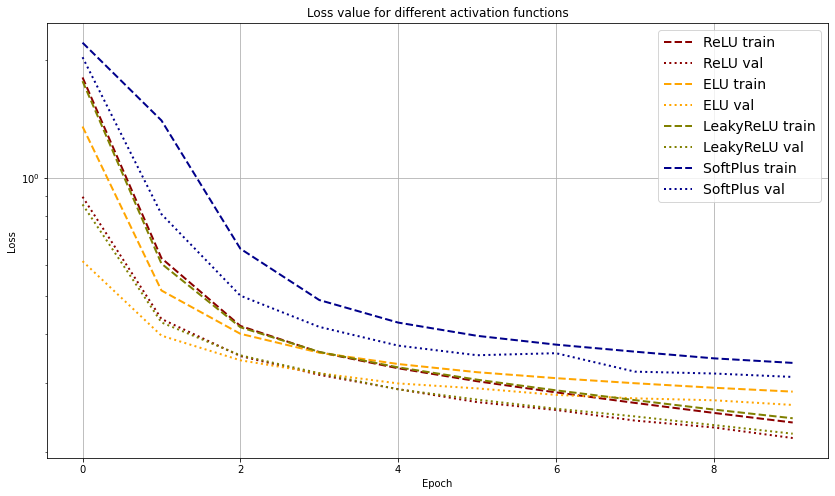

In [81]:
# Plot loss value of different activation functions
plt.figure(figsize=(14, 8))

for i, activ_func in enumerate(activation_functions):
    plt.plot(train_losses[i], '--', color=colors[i], lw=2, label=f'{activ_func} train')
    plt.plot(val_losses[i], ':', color=colors[i], lw=2, label=f'{activ_func} val')

plt.title("Loss value for different activation functions")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

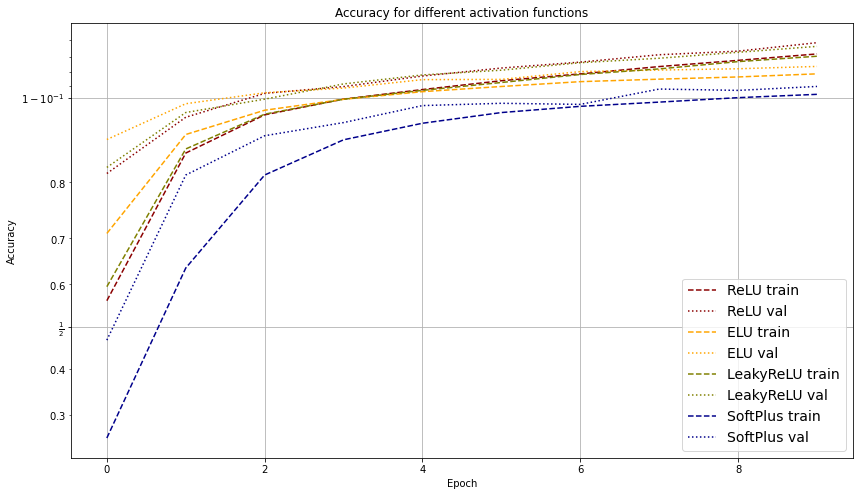

In [84]:
# Plot accuracy of different activation functions
plt.figure(figsize=(14, 8))

for i, activ_func in enumerate(activation_functions):
    plt.plot(train_accuracy[i], '--', color=colors[i], label=f'{activ_func} train')
    plt.plot(val_accuracy[i], ':', color=colors[i], label=f'{activ_func} val')

plt.title("Accuracy for different activation functions")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.yscale('logit')
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

<i>Замечание<i>: К общему минусу нижеперечисленных функций активаций можно отнести их неограниченность

1) `ReLU`: Плюсы - легко и быстро вычисляется. 
Минусы - обнуляет градиент, состоит из линейных частей.  

2) `ELU`  Минусы - нейронная сеть не может варьировать параметр наклона, равен нулю при больших по модулю отрицательных значениях (ввиду ограниченной машинной точности), дольше вычисляется по сравнению с `ReLU`. Плюсы - сочетает в себе линейную и нелинейную части, частично решена проблема с затуханием градиента

3) `LeakyReLU` Плюсы - те же, что и для `ReLU` + не зануляет градиент. Минусы - нейронная сеть не может варьировать параметр наклона, состоит из линейных частей.  

4) `SoftPlus` Плюсы - везде дифф-ма, нелинейная (хотя асимптоты - линейные), частично решена проблема с затуханием градиента. Минусы - долго вычисляется, равна нулю при больших по модулю отрицательных значениях

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [63]:
# Test batch norm.
activ_func = 'LeakyReLU'

optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.5}
optimizer_state = {}

norm_model = build_model(activation_func=activ_func, norm=True)
norm_losses, norm_accuracy = train_model(norm_model, 
                                       {'train': X_train, 'val': X_val}, 
                                       {'train': y_train_ohe, 'val': y_val_ohe}, 
                                       batch_size, 
                                       sgd_momentum,
                                       criterion,
                                       n_epoch)
norm_test_acc = test_model(norm_model, X_test, y_test_ohe, batch_size)


optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.5}
optimizer_state = {}

model = build_model(activation_func=activ_func, norm=False)
losses, accuracy = train_model(model, 
                               {'train': X_train, 'val': X_val}, 
                               {'train': y_train_ohe, 'val': y_val_ohe}, 
                               batch_size, 
                               sgd_momentum,
                               criterion,
                               n_epoch)
test_acc = test_model(model, X_test, y_test_ohe, batch_size)

100%|███████████████████████████████████████████| 10/10 [13:02<00:00, 78.28s/it]


Training complete in 13m 3s


100%|███████████████████████████████████████████| 10/10 [01:15<00:00,  7.52s/it]


Training complete in 1m 15s


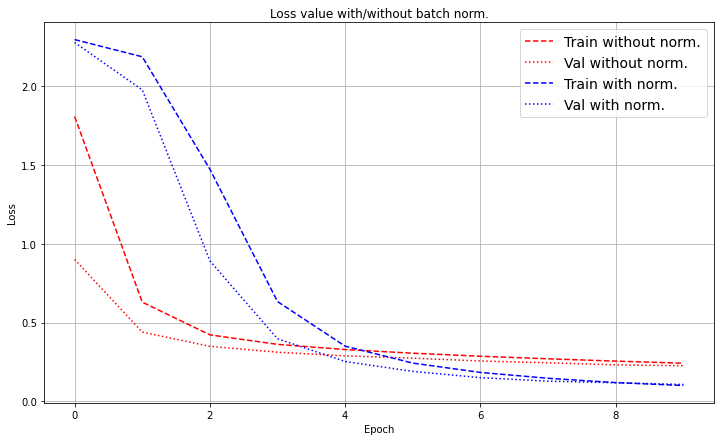

In [64]:
# Plot loss value with/without batch norm.
plt.figure(figsize=(12, 7))

plt.plot(losses['train'], '--', color='red', label='Train without norm.')
plt.plot(losses['val'], ':', color='red', label='Val without norm.')
plt.plot(norm_losses['train'], '--', color='blue', label='Train with norm.')
plt.plot(norm_losses['val'], ':', color='blue', label='Val with norm.')

plt.title("Loss value with/without batch norm.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

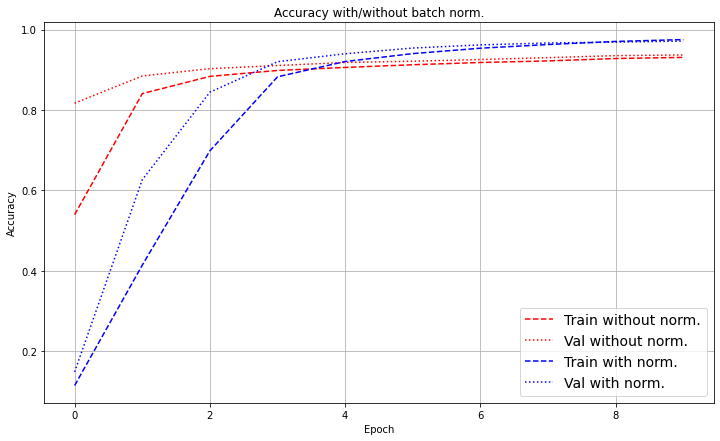

Test accuracy without norm. = 0.9339
Test accuracy with norm. = 0.9729


In [74]:
# Plot accuracy with/without batch norm.
plt.figure(figsize=(12, 7))

plt.plot(accuracy['train'], '--', color='red', label='Train without norm.')
plt.plot(accuracy['val'], ':', color='red', label='Val without norm.')
plt.plot(norm_accuracy['train'], '--', color='blue', label='Train with norm.')
plt.plot(norm_accuracy['val'], ':', color='blue', label='Val with norm.')

plt.title("Accuracy with/without batch norm.")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

print("Test accuracy without norm. =", test_acc)
print("Test accuracy with norm. =", norm_test_acc)

**Вывод**: Исходя из графиков, добавление `BatchNormalization` в нашу модель немного улучшило качество предсказания. Более того, результат на тестовой выборке увеличился на 0.04

In [77]:
# Adam vs SGD}
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
optimizer_state = {}

adam_model = build_model(activation_func=activ_func, norm=True)
adam_losses, adam_accuracy = train_model(adam_model, 
                                       {'train': X_train, 'val': X_val}, 
                                       {'train': y_train_ohe, 'val': y_val_ohe}, 
                                       batch_size, 
                                       adam_optimizer,
                                       criterion,
                                       n_epoch)
adam_test_acc = test_model(adam_model, X_test, y_test_ohe, batch_size)

100%|███████████████████████████████████████████| 10/10 [12:21<00:00, 74.18s/it]


Training complete in 12m 22s


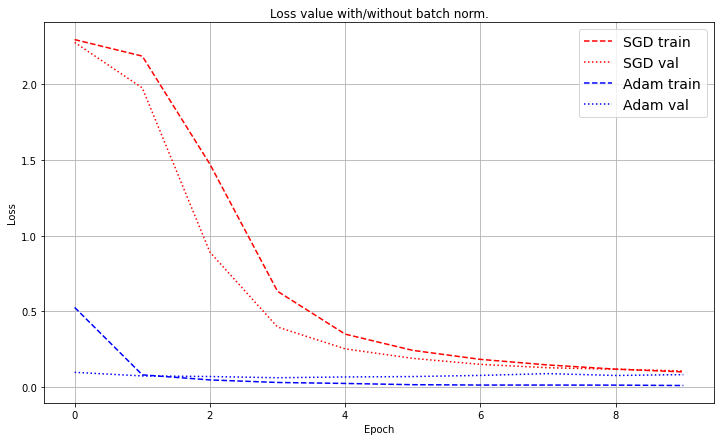

In [79]:
# Plot loss value for Adam and SGD
plt.figure(figsize=(12, 7))

plt.plot(norm_losses['train'], '--', color='red', label='SGD train')
plt.plot(norm_losses['val'], ':', color='red', label='SGD val')
plt.plot(adam_losses['train'], '--', color='blue', label='Adam train')
plt.plot(adam_losses['val'], ':', color='blue', label='Adam val')

plt.title("Loss value with/without batch norm.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

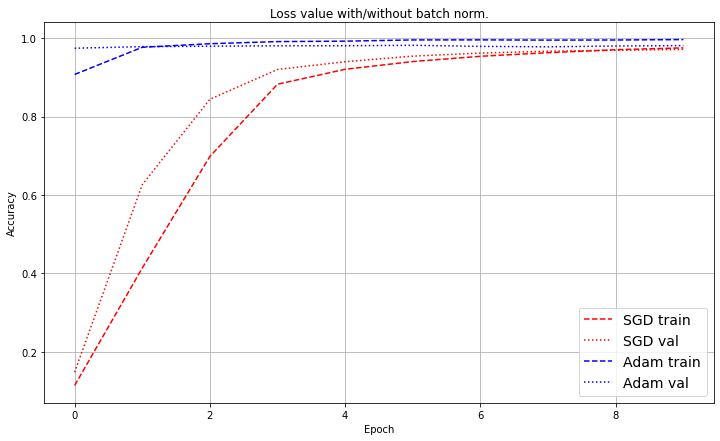

Test accuracy for Adam = 0.9798
Test accuracy for SGD = 0.9729


In [80]:
# Plot accuracy for Adam and SGD
plt.figure(figsize=(12, 7))

plt.plot(norm_accuracy['train'], '--', color='red', label='SGD train')
plt.plot(norm_accuracy['val'], ':', color='red', label='SGD val')
plt.plot(adam_accuracy['train'], '--', color='blue', label='Adam train')
plt.plot(adam_accuracy['val'], ':', color='blue', label='Adam val')

plt.title("Loss value with/without batch norm.")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

print("Test accuracy for Adam =", adam_test_acc)
print("Test accuracy for SGD =", norm_test_acc)

**Вывод**: Исходя из графиков, оптимизатор Adam гораздо быстрее приближается к минимуму функции потерь, чем SGD.  
Однако качество на тестовой выборке у Adam-а лишь незначительно лучше, поскольку SGD успевает "догнать" Adam-а за 10 эпох обучения модели

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [86]:
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
optimizer_state = {}

top_model = build_model(activation_func=activ_func, norm=True, dropout=True)
top_losses, top_accuracy = train_model(top_model, 
                               {'train': X_train, 'val': X_val}, 
                               {'train': y_train_ohe, 'val': y_val_ohe}, 
                               batch_size, 
                               adam_optimizer,
                               criterion,
                               n_epoch=16, 
                               lr_scheduler_step_size=7, 
                               lr_scheduler_coef=0.1)

top_test_acc = test_model(model, X_test, y_test_ohe, batch_size)

100%|███████████████████████████████████████████| 16/16 [19:32<00:00, 73.28s/it]


Training complete in 19m 32s


Print here your accuracy on test set. It should be around 90%.

In [87]:
print("Test accuracy =", top_test_acc)

Test accuracy = 0.9783


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [34]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

import mnist
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time


X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
print(device)

cuda


In [6]:
SIZE_H = 28
SIZE_W = 28

NUM_CLASSES = 10

NUM_WORKERS = 2

EPOCH_NUM = 20

BATCH_SIZE = 256

# grayscale ImageNet's train dataset mean and standard deviation
image_mean = [0.445]
image_std  = [0.269]

EMBEDDING_SIZE = 128

In [8]:
class DatasetMNIST(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.ColorJitter(),
        transforms.RandomInvert(),
        transforms.Normalize(image_mean, image_std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(image_mean, image_std)
    ]),
}

In [11]:
train_dataset = DatasetMNIST(X_train, y_train, data_transforms['train'])
val_dataset = DatasetMNIST(X_val, y_val, data_transforms['val'])
test_dataset = DatasetMNIST(X_test, y_test, data_transforms['val'])

In [12]:
train_batch_gen = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                             num_workers=NUM_WORKERS)
val_batch_gen = DataLoader(val_dataset, BATCH_SIZE, NUM_WORKERS)
test_batch_gen = DataLoader(test_dataset, BATCH_SIZE, NUM_WORKERS)

In [13]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = data_batch[i].numpy()[0, :, :]
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d' % (label_batch[i])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

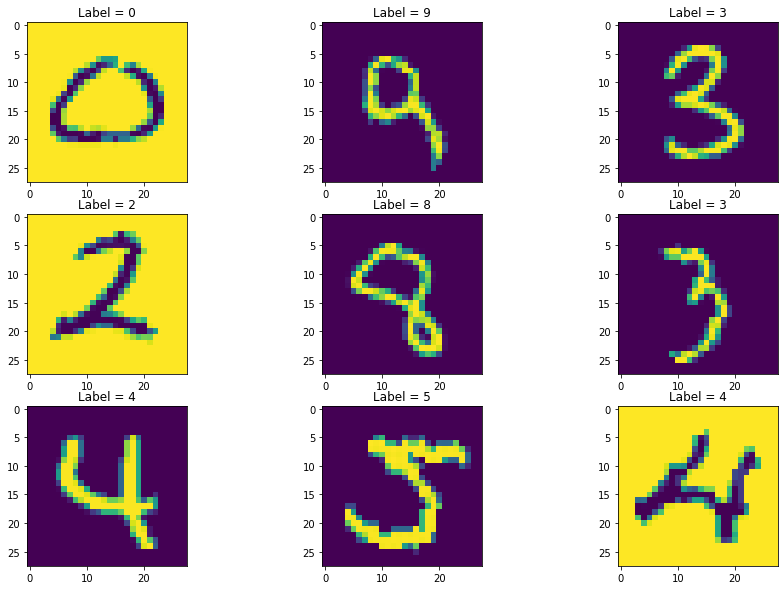

In [16]:
plot_from_batch_generator(train_batch_gen)

In [59]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs, 
                                                            lr_scheduler=None):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model.forward(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        if lr_scheduler:
            lr_scheduler.step()

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # compute predictions
                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch)
                ep_val_loss.append(loss.item())

                y_pred = preds.argmax(dim=1)
                acc = torch.sum(y_pred == y_batch).item() / y_batch.size()[0]
                ep_val_accuracy.append(acc)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [38]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 500, bias=False), 
    nn.BatchNorm1d(500),
    nn.LeakyReLU(),
    nn.Linear(500, 250, bias=False),
    nn.BatchNorm1d(250),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(250, 10),
).to(device)

In [39]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [60]:
train_loss, val_loss, val_acc = train_model(model, 
                                            train_batch_gen, 
                                            val_batch_gen, 
                                            loss_func, 
                                            optimizer, 
                                            EPOCH_NUM, 
                                            lr_scheduler)

Epoch 1 of 20 took 31.505s
	  training loss: 0.153685
	validation loss: 0.121296
	validation accuracy: 0.962
Epoch 2 of 20 took 31.556s
	  training loss: 0.132718
	validation loss: 0.106960
	validation accuracy: 0.969
Epoch 3 of 20 took 31.762s
	  training loss: 0.129798
	validation loss: 0.105060
	validation accuracy: 0.967
Epoch 4 of 20 took 31.776s
	  training loss: 0.087977
	validation loss: 0.075530
	validation accuracy: 0.977
Epoch 5 of 20 took 31.478s
	  training loss: 0.076659
	validation loss: 0.069443
	validation accuracy: 0.978
Epoch 6 of 20 took 31.667s
	  training loss: 0.070585
	validation loss: 0.072704
	validation accuracy: 0.977
Epoch 7 of 20 took 31.306s
	  training loss: 0.070207
	validation loss: 0.069005
	validation accuracy: 0.979
Epoch 8 of 20 took 31.571s
	  training loss: 0.066629
	validation loss: 0.067352
	validation accuracy: 0.978
Epoch 9 of 20 took 31.421s
	  training loss: 0.067351
	validation loss: 0.073468
	validation accuracy: 0.975
Epoch 10 of 20 took

In [63]:
def test_model(model, test_loader):
    with torch.no_grad():
        model.eval()
        right_preds, total_preds = 0, 0
    
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = model(inputs)
            right_preds += torch.sum(preds.argmax(dim=1) == targets).item()
            total_preds += targets.size()[0]
            
    return right_preds / total_preds

In [65]:
test_acc = test_model(model, test_batch_gen)
print("Test accuracy =", test_acc)

Test accuracy = 0.9797
